In [ ]:
!pip install hpsklearn
!pip install --upgrade --quiet neptune-client
!pip install neptune-optuna

In [ ]:
!pip uninstall future
!pip install future==0.13.1

In [ ]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe

import neptune.new as neptune

# **Neptune integration**

In [117]:
NEPTUNE_API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1Yjc4NDczMC0zNzc1LTQ0ZjEtYTYwYS0wMjNhNjNhMDNiOGEifQ=="
run = neptune.init(project='marcelmilosz/projekt-ml', api_token=NEPTUNE_API_TOKEN)

params = {
    "optimizer": "Marcel"
}
run["parameters"] = params


def send_data_neptune(data, plot_name):
    """ Sending array with data to neptune"""

    for epoch in range(0, len(data)):
      run[plot_name].log(data[epoch])

def single_record(record, record_name):
    """ Sending single record to neptune """

    run[record_name] = record

def stop_run():
    """ Stoping run at the end of the program """

    run.stop()


https://app.neptune.ai/marcelmilosz/projekt-ml/e/PROJ-91
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
os.environ["OMP_NUM_THREADS"] = "1"

In [6]:
seed = np.random.seed(147)

In [121]:
def data_load() -> list:
    """Loading csv files to DataFrames"""
    
    train_data = pd.read_csv("/content/drive/MyDrive/Projekt_ML_26.06.2021/train_data.csv", header=None)
    test_data = pd.read_csv("/content/drive/MyDrive/Projekt_ML_26.06.2021/test_data.csv", header=None)
    train_labels = pd.read_csv("/content/drive/MyDrive/Projekt_ML_26.06.2021/train_labels.csv", header=None)
    

    ## Save to neptune train labels
    a = train_labels.values
    tmp = []
    for i in range(0, len(a)):
      tmp.append(int(a[i]))

    send_data_neptune(tmp, "train_labels")


    return [train_data, test_data, train_labels]

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
train_data, test_data, train_labels = data_load()

In [123]:
train_labels_ravel = train_labels.values.ravel()

# Preprocessing

### problem: multidimensional dataset, 
### solution: dimensional reduction (Correlation Heatmap, Univariate Selection/ PCA - Principal Component Analysis/ RFE - Recursive Feature Elimination)

In [124]:
def pipe_std_minmax(X_1, X_2: pd.DataFrame) -> np.array:
    """Data standardization and normalization"""
    
    pipe = Pipeline([
    ("std", StandardScaler()),
    ("minmax", MinMaxScaler())
    ])
    
    train_std_minmax = pipe.fit_transform(X_1)
    test_std_minmax = pipe.fit_transform(X_2)
    
    return [train_std_minmax, train_std_minmax]

In [125]:
train_std_minmax, test_std_minmax = pipe_std_minmax(train_data, test_data)

In [126]:
k=int(len(train_data.columns)/3)

In [128]:
def univariate_select(X_1, X_2, y_1: np.array, n_of_kbest: int) -> np.array:
    """Univariate Selection"""
    
    print(f"Shape before: {X_1.shape}\n")
    
    test = SelectKBest(score_func=f_classif, k=n_of_kbest)
    fit = test.fit(X_1, y_1)
    features_1 = fit.transform(X_1)
    features_2 = fit.transform(X_2)
    
    scores = fit.scores_
    score_df = pd.DataFrame(scores, columns=["Scores"])
    print(f"Min score: {min(score_df.Scores)}, max score: {max(score_df.Scores)}, mean score: {np.mean(score_df.Scores)}\n")    
    print(f"Shape after: {features_1.shape}\n")
    
    score_df.drop(score_df[score_df.Scores < 1].index, inplace=True)
    l = len(score_df)

    single_record(min(score_df.Scores), 'univariate_select_min_score')
    single_record(max(score_df.Scores), 'univariate_select_max_score')
    single_record(np.mean(score_df.Scores), 'univariate_select_mean_score')
    
    if l != n_of_kbest:
        return univariate_select(train_std_minmax, test_std_minmax, train_labels_ravel, l)
    else:
        return [features_1, features_2]
    

In [129]:
univariate_train, univariate_test = univariate_select(train_std_minmax, test_std_minmax, train_labels_ravel, k)

Shape before: (3750, 10000)

Min score: 1.7507493403703283e-09, max score: 17.32125589248371, mean score: 1.0003800117276054

Shape after: (3750, 3333)

Shape before: (3750, 10000)

Min score: 1.7507493403703283e-09, max score: 17.32125589248371, mean score: 1.0003800117276054

Shape after: (3750, 3177)



In [130]:
def pca_select(X_1, X_2: np.array) -> np.array:
    """Principal Component Analysis"""
    
    print(f"Shape before: {X_1.shape}\n")
    
    pca = PCA(n_components=100, random_state=seed)
    fit = pca.fit(X_1)
    features_1 = fit.transform(X_1)
    features_2 = fit.transform(X_2)
    
    print(f"Explained Variance: \n{fit.explained_variance_ratio_}\n")
    print(f"Shape after: {features_1.shape}")

    send_data_neptune(fit.explained_variance_ratio_, "explained_variance_ration")
    
    return [features_1, features_2]

In [131]:
pca_train, pca_test = pca_select(univariate_train, univariate_test)

Shape before: (3750, 3177)



Explained Variance: 
[0.00119608 0.00115896 0.00115038 0.00114678 0.00114298 0.00114194
 0.00113526 0.00113021 0.00112682 0.00112268 0.00112052 0.00111851
 0.00111176 0.00110753 0.00110516 0.00110244 0.00109764 0.00109656
 0.00109259 0.00108964 0.0010877  0.00108548 0.0010836  0.00108306
 0.00108098 0.00107789 0.00107471 0.00106934 0.00106777 0.0010657
 0.0010633  0.00105987 0.00105895 0.00105479 0.00105312 0.00105262
 0.00105081 0.00104945 0.00104638 0.00104521 0.00104251 0.00103968
 0.00103806 0.00103519 0.00103338 0.00103127 0.00102891 0.00102831
 0.00102628 0.00102303 0.00102108 0.00101921 0.00101665 0.00101465
 0.00101295 0.00100956 0.0010084  0.00100719 0.00100425 0.00100226
 0.00100023 0.00099791 0.00099698 0.00099298 0.00099058 0.00098987
 0.00098695 0.0009843  0.00098307 0.00098103 0.00097847 0.00097724
 0.00097485 0.00097317 0.00097098 0.00097062 0.00096806 0.00096532
 0.00096332 0.00096183 0.00095891 0.00095866 0.00095371 0.00095153
 0.00095042 0.00094843 0.00094522 0.000943

In [133]:
def rfe_select(X_1, X_2, y_1: np.array) -> np.array:
    """Recursive Feature Elimination"""
    
    print(f"Shape before: {X_1.shape}\n")
    
    svc = SVC(kernel="linear", C=1, random_state=seed)
    rfe = RFE(estimator=svc, n_features_to_select=5)
    fit = rfe.fit(X_1, y_1)
    features_1 = fit.transform(X_1)
    features_2 = fit.transform(X_2)
    
    print(f"Feature Ranking: \n{fit.ranking_}\n")
    print(f"Shape after: {features_1.shape}\n")

    send_data_neptune(fit.ranking_, "fit-ranking")
    
    return [features_1, features_2]

In [134]:
rfe_train, rfe_test = rfe_select(pca_train, pca_test, train_labels_ravel)

Shape before: (3750, 100)

Feature Ranking: 
[ 1 91  6 93  1 63  2 69 11 52 47  7 76  1 54 56 64  3 42 10 40 26 53  1
 15 50 89 95 72 43 71 90 38 13 68 39 22 81 87 46 85 27 41 24 96 34 25 80
 83 29 33 55  9 23 36 12 45 70  8 73 31 94 28 51  4 78 79 84 88 61 75 77
 66  5 14 32 19 48 21  1 60 92 74 49 16 58 17 18 20 86 37 62 57 82 65 35
 59 44 67 30]

Shape after: (3750, 5)



### problem: unbalanced dataset, 
### solution: Random Oversampling/SMOTE

In [135]:
from imblearn.pipeline import Pipeline

In [137]:
def random_sampling(X_1, y_1: np.array) -> list:
    """Random Oversampling/Undersampling"""
    
    over = RandomOverSampler(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    X_resampled, y_resampled = pipeline.fit_resample(X_1, y_1)

    ## Save X and y resampled to neptune

    tmp_X = []
    for i in range(0, len(X_resampled)):
      for j in range(0, len(X_resampled[i])):
        tmp_X.append(X_resampled[i][j])
    
    send_data_neptune(tmp_X, "X-resampled")
    send_data_neptune(y_resampled, "y-resampled")
    
    
    return [X_resampled, y_resampled]

In [138]:
X_resampled, y_resampled = random_sampling(rfe_train, train_labels_ravel)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [139]:
def save_data(train_X, test_X, train_y: np.array) -> None:
    """Save to npy file"""
    
    np.save('/content/drive/MyDrive/Projekt_ML_26.06.2021/processed_train_X.npy', train_X)
    np.save('/content/drive/MyDrive/Projekt_ML_26.06.2021/processed_test_X.npy', test_X)
    np.save('/content/drive/MyDrive/Projekt_ML_26.06.2021/processed_train_y.npy', train_y)
    
    print("Saving has been completed.")

In [140]:
save_data(X_resampled, rfe_test, y_resampled)

Saving has been completed.


# EDA part 2

In [ ]:
df = pd.DataFrame(X_resampled, index=None, columns=None)

In [ ]:
def correlation_heatmap(data: pd.DataFrame) -> plt:
    """Correlation heatmap for preprocessed train data"""
    
    plt.figure(figsize=(16.9, 8))
    heat_mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), mask=heat_mask, vmin=-1, vmax=1, annot=True)
    plt.title("Correlation heatmap for preprocessed train data")
    
    return plt.show()

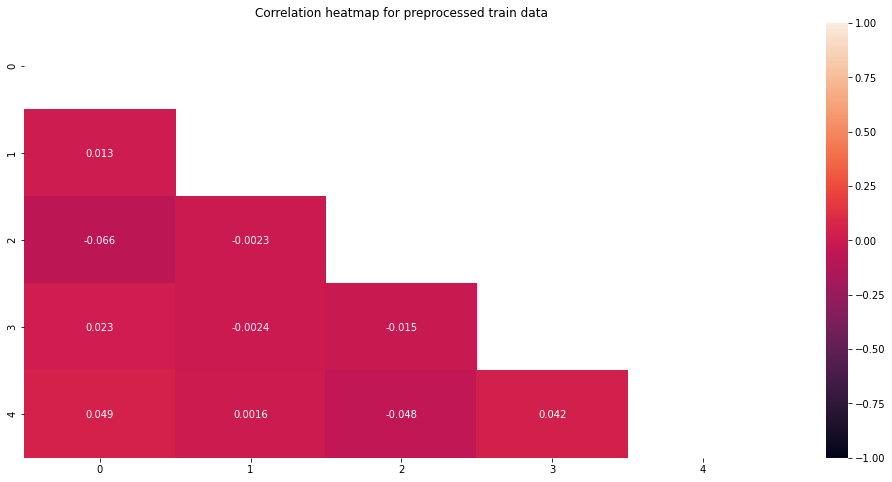

In [ ]:
correlation_heatmap(df)

In [ ]:
def pair_plot(data: pd.DataFrame) -> plt:
    """Pair plot for preprocessed train data"""

    plt.figure(figsize=(14,8))    
    g = sns.pairplot(data, corner=True)
    g.fig.suptitle("Pair plot for preprocessed train data")

    return plt.show()

<Figure size 1008x576 with 0 Axes>

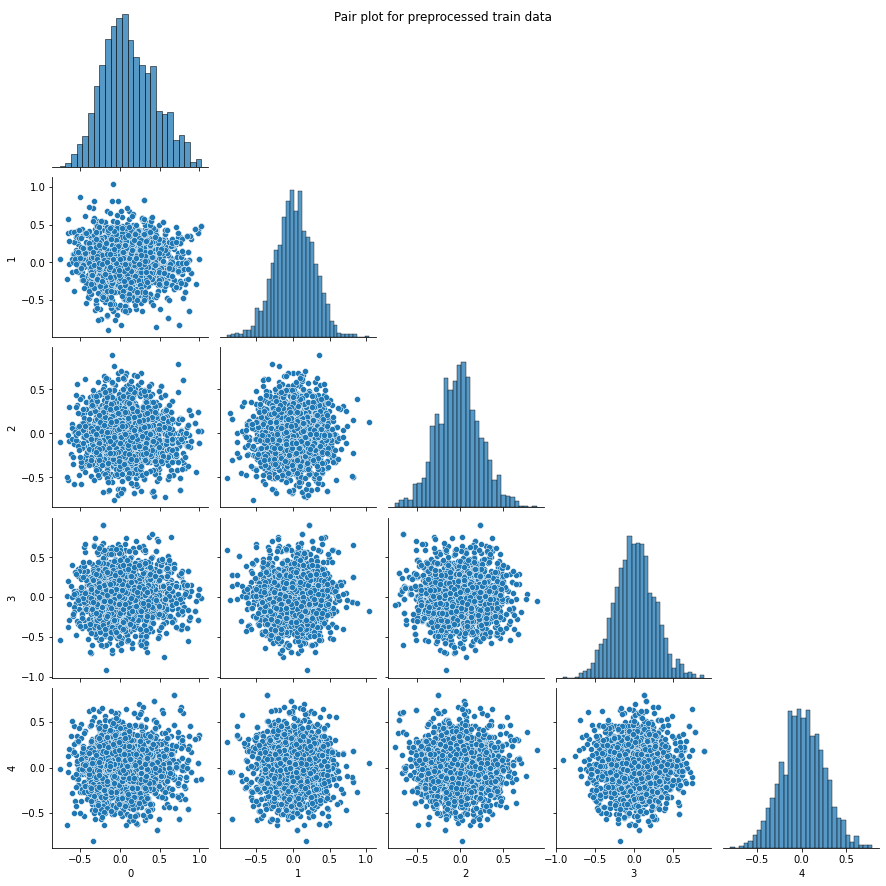

In [ ]:
pair_plot(df)

In [ ]:
def box_plot(data: pd.DataFrame) -> plt:
    """Box plot for preprocessed train data"""
    
    plt.figure(figsize=(15.2, 8))
    sns.boxplot(data=data)
    plt.title("Box plot for preprocessed train data")
    
    return plt.show()

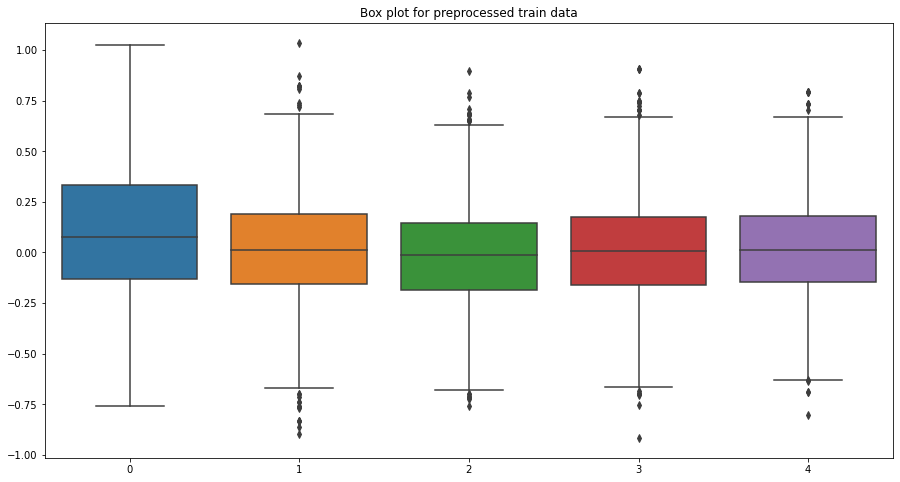

In [ ]:
box_plot(df)

In [ ]:
def scatter_plot(X_1, y_1: np.array) -> plt:
    """Summarize class distribution and plot scatter for preprocessed train data"""

    counter = Counter(y_1)

    plt.figure(figsize=(15.1, 13))
    for label, _ in counter.items():
        row_ix = np.where(y_1 == label)[0]
        plt.scatter(X_1[row_ix, 0], X_1[row_ix, 1], label=str(label), 
                    s=100, marker="o", alpha=0.5, edgecolor="black")
    plt.title(f"Scatter plot for preprocessed data with {counter}")
    plt.legend()
    
    return plt.show()

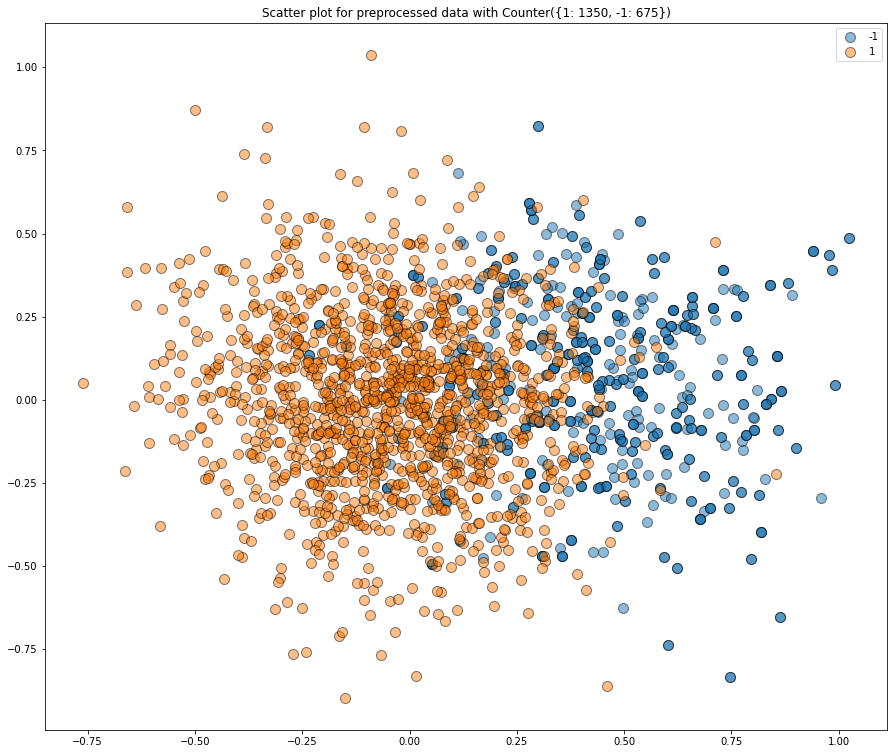

In [ ]:
scatter_plot(X_resampled, y_resampled)

# Basic Models

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=seed)

In [142]:
def pipe_basic_model(X_1, X_2, y_1, y_2: np.array) -> None:
    """Base line model picking with repeated skf, gridsearchcv in pipeline"""
    
    pipe = Pipeline([("classifier", SVC(kernel="linear", C=1, random_state=seed))])
    
    search_space = [
        {"classifier": [SVC(random_state=seed)]},
        {"classifier": [LinearSVC(random_state=seed)]},
        {"classifier": [LogisticRegression(random_state=seed)]},
        {"classifier": [KNeighborsClassifier()]},
        {"classifier": [MLPClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GradientBoostingClassifier(random_state=seed)]},
        {"classifier": [RandomForestClassifier(random_state=seed)]},
        {"classifier": [ExtraTreesClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GaussianNB()]}
    ]
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=rskf, verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(X_1, y_1)
    y_pred = best_model.predict(X_2)
    
    print(f"\nBest model: {best_model.best_estimator_.get_params()['classifier']}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    single_record(f1_score(y_2, y_pred, average='micro'), "f1-score")

In [143]:
pipe_basic_model(X_train, X_test, y_train, y_test)

Fitting 50 folds for each of 11 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.4min finished



Best model: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Micro-averaged F1 score on test set: 0.925


In [156]:
def hyperopt_model(X_1, X_2, y_1, y_2: np.array) -> None:
    """Hyperopt model picking"""

    model = HyperoptEstimator(
        classifier=any_classifier("cla"),
        preprocessing=any_preprocessing("pre"),
        algo=tpe.suggest,
        max_evals=10,
        trial_timeout=30)
    
    model.fit(X_1, y_1)
    y_pred = model.predict(X_2)
    
    print(f"\nBest model: {model.best_model()}")
    print("\nMicro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_2, y_pred, average='micro'))
    
    send_data_neptune(y_pred, "y_pred")
    single_record(f1_score(y_2, y_pred, average='micro'), "Micro-averaged F1 Score")

In [157]:
hyperopt_model(X_train, X_test, y_train, y_test)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



100%|██████████| 1/1 [00:30<00:00, 30.32s/it, best loss: 0.09210526315789469]

Best model: {'learner': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None,
                       max_features=0.2188325305088784, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=210, n_jobs=1, oob_score=False,
                       random_state=2, verbose=False, warm_start=False), 'preprocs': (PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True),), 'ex_preprocs': ()}

Micro-averaged F1 score on test set: 0.850


In [158]:
stop_run()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!
